# TP3 - Fine tuning

L'objectif de ce TP est de présenter comment exploiter les modèles disponibles sur HuggingFace, plus particulièrement pour des tâches de classification. Nous mettrons également en pratique l'approche [*Two-stage fine-tuning*](https://arxiv.org/pdf/2207.10858).

## Contexte

Les flux RSS, de l'anglais *Rich Site Summary*, est un flux d'information pour partager simplement des informations. Largement utilisé dans le domaine de la communication par les médias, nous pouvons nous tenir au courant des informations que les journaux partagent par exemple.
Cependant, le volume d'informations peut être rapidement très important pour pouvoir être lu. On se propose de construire un filtre pour nous notifier uniquement quand une information sera jugée *d'intérêt*.

Pour cela, nous avons sauvegardé puis labellisé les flux RSS de plusieurs journaux mondiaux en anglais, pendant plusieurs semaines. Importons et visualisons la bases de données à disposition.

In [25]:
import pandas as pd

df = pd.read_csv("data/Complete.csv")

df["published"] = pd.to_datetime(df["published"])
df = df.loc[~df["target"].isna()].copy()
df["target"] = df["target"].astype(int)


imbalanced_rate = df["target"].mean()
print(f"{df.shape[0]} news with {100 * imbalanced_rate:.2f}% of positive class")

df.head()

7619 news with 10.59% of positive class


provider category                                               link  \
0  El Pais    World  https://english.elpais.com/climate/2025-12-27/...   
1  El Pais    World  https://english.elpais.com/climate/2025-12-31/...   
2  El Pais    World  https://english.elpais.com/climate/2026-01-01/...   
3  El Pais    World  https://english.elpais.com/climate/2026-01-03/...   
4  El Pais    World  https://english.elpais.com/climate/2026-01-05/...   

                  published  \
0 2025-12-27 04:00:00+00:00   
1 2025-12-31 13:53:41+00:00   
2 2026-01-01 12:24:15+00:00   
3 2026-01-03 04:45:00+00:00   
4 2026-01-05 17:02:27+00:00   

                                               title  \
0  A floating school teaches children how to save...   
1  David King, chemist: ‘There are scientists stu...   
2  Cartagena de Indias is sinking: What can the c...   
3  The secrets of the Washingtonia palm, named af...   
4  A recipe for resistance: Indigenous peoples po...   

                                             summary  target  
0  This is the latest attempt by Guatemalan scien...       0  
1  The British researcher is calling for global r...       0  
2  Sea levels in the bay of the Colombian resort ...       0  
3  They are among the most widely cultivated plan...       0  
4  A book that compiles the recovery of ancestral...       0

## Préparation

Nous n'allons exploiter que le titre et le contenu du flux RSS, et avant de commencer nous allons nettoyer un peu le texte.

In [26]:
def clean_text(title: str, summary: str) -> str:
    """Clean the title and summary strings."""

    def clean_string(string: str) -> str:
        """Clean a single string."""
        string = string.lower()
        string = string.replace("(Source: Bloomberg)", "")
        string = string.replace("“", "'")
        string = string.replace("”", "'")
        string = string.replace("\n", "")
        string = string.replace("  ", " ")
        return string.strip()

    title = clean_string(title)
    summary = clean_string(summary)

    return f"Title: {title}\nSummary: {summary}"


df["text"] = df.apply(lambda row: clean_text(row["title"], row["summary"]), axis=1)

Puisque le dataset est dépendant du temps, nous allons le découper en jeu d'entraînement et de validation en suivant cela.

In [27]:
train_ratio = 0.8

df = df.drop_duplicates(subset=["text"])
df = df.sort_values("published")
split_date = df["published"].quantile(train_ratio)

df_train = df[df["published"] <= split_date][["text", "target"]]
df_val = df[df["published"] > split_date][["text", "target"]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(
    f"Training size:   {len(df_train)}, imbalanced rate: {100 * df_train.target.mean():.2f}%",
)
print(
    f"Validation size: {len(df_val)}, imbalanced rate: {100 * df_val.target.mean():.2f}%",
)

Training size:   6092, imbalanced rate: 10.69%
Validation size: 1523, imbalanced rate: 10.18%


Puisque nous avons un déséquilibre, nous allons le reporter dans la fonction de perte. Pour préparer cette étape, nous allons utiliser la fonction [`compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) et stocker son résultat dans un [`Tensor`](https://docs.pytorch.org/docs/stable/tensors.html) de PyTorch pour l'exploiter dans la fonction de perte.

In [28]:
import numpy as np

import torch
from sklearn.utils.class_weight import compute_class_weight

labels = df_train["target"].to_numpy()
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=labels,
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(class_weights)

tensor([0.5598, 4.6790])


## Premier entraînement

Il est maintenant temps de basculer du monde classique numpy, pandas, scikit-learn à celui de la librairies transformers d'HuggingFace.

### Dataset d'entraînement

On ne travaille plus avec des DataFrames pandas mais des [Datasets](https://huggingface.co/docs/datasets/use_with_pandas). 

In [29]:
from datasets import Dataset

ds_train = Dataset.from_pandas(df_train)
ds_val = Dataset.from_pandas(df_val)

ds_train = ds_train.rename_column("target", "labels")
ds_val = ds_val.rename_column("target", "labels")

Le texte contenu dans les datasets n'est pas *compréhensible* en l'état par un modèle: nous devons **tokeniser** le texte. Nous devons le faire en utilisant la même méthode qui a servit à entraîner le modèle que nous utiliserons par la suite : nous choisissons [DistilRoBERTa base](https://huggingface.co/distilbert/distilroberta-base). Le choix s'est fait sur les capacités du modèle et sa taille réduite pour permettre des itérations *rapide*.

In [30]:
from transformers import AutoTokenizer

MODEL_NAME = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize(batch: dict) -> dict:
    """Tokenize a batch of texts."""
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )


ds_train = ds_train.map(tokenize, batched=True)
ds_val = ds_val.map(tokenize, batched=True)

Map: 100%|██████████| 1523/1523 [00:00<00:00, 16717.37 examples/s]


Dans cette cellule nous avons réutiliser le tokenizer du modèle d'intérêt puis l'avons appliquer à la colonne contenant le texte. A présent, le dataset n'est plus composé de deux colonnes (labels et target) mais :

In [31]:
ds_train

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 6092
})

Avant de continuer, nous changeons le format des données en tenseur torch.

In [32]:
ds_train.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)
ds_val.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

La librairie transformers n'a pas de méthode `fit` comme dans scikit-learn ou Keras, mais une classe [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer).
Nativement, cette classe ne prend pas en compte le déséquilibre : nous allons la modifier pour le faire. On se propose d'hériter de la classe `Trainer` et de modifier uniquement la méthode `compute_loss` pour qu'elle utilise la [`CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) de PyTorch.

In [33]:
import torch
from transformers import Trainer


class WeightedTrainer(Trainer):
    """Custom Trainer with weighted loss to handle class imbalance."""

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs = False,
        num_items_in_batch = None,
    ):
        """Compute the weighted cross-entropy loss for class imbalance."""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Configuration de la perte avec les poids de classe
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))

        # Calcul de la perte
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


Tout au long de l'entraînement du modèle, nous voulons être capable de suivre ses performances, en plus de la valeur de la fonction de perte. Nous définissons une fonction pour répondre à cet objectif :

In [34]:
import scipy.special as sp

from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    precision_recall_fscore_support,
)


def compute_metrics(eval_pred: tuple) -> dict:
    """Compute evaluation metrics."""
    logits, y_true = eval_pred
    probas = sp.softmax(logits, axis=1)[:, 1]

    threshold = 0.5
    y_pred = (probas >= threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="binary",
        zero_division=0,
    )

    auprc = average_precision_score(y_true, probas, average="weighted")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy_score(y_true, y_pred),
        "auprc": auprc,
    }


Pour paramétrer la classe `Trainer`, nous allons utiliser la classe [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=1e-4,
    weight_decay=0.0,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_strategy="epoch",
    report_to=[],
    save_total_limit=1,
)

Il est enfin temps de lancer l'entraînement !

**Consigne** :
1. Initialiser le modèle à l'aide de la classe [`AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification), on valorisera le paramètre `num_labels` à 2 puisque nous réalisons une classification binaire.
2. Initialiser le `WeightedTrainer` avec :
    * Le modèle définit à l'étape précédente
    * Comme arguments (args) le paramètrage d'entraînement défini dans la cellule précédente
    * Les datasets d'entraînement et de test
    * La fonction de mesure de performance
3. Lancer l'entraînement avec la méthode `train` du `Trainer`

In [36]:
from transformers import AutoModelForSequenceClassification

classifier = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)

trainer = WeightedTrainer(
    model=classifier,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=573, training_loss=0.40664318677226496, metrics={'train_runtime': 1411.5979, 'train_samples_per_second': 12.947, 'train_steps_per_second': 0.406, 'total_flos': 1210487088918528.0, 'train_loss': 0.40664318677226496, 'epoch': 3.0})

On aimerait visualiser la performance et la distribution des réponses du modèles. Pour cela, on produit deux graphes :
1. Graphique de distribution des probabilités du modèle sur le dataset de validation
2. Graphique de valeurs des principales métriques (précision, recall et f1-score) en fonction du seuil

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style="whitegrid")


def metrics_vs_threshold(
    y_true: np.ndarray,
    y_proba: np.ndarray,
    thresholds: np.ndarray,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute precision, recall, and F1-score for various thresholds.

    Args:
        y_true (np.ndarray): True binary labels.
        y_proba (np.ndarray): Predicted probabilities for the positive class.
        thresholds (np.ndarray): Array of thresholds to evaluate.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: Precision, recall, and F1-score arrays.

    """
    precision, recall, f1 = [], [], []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        p, r, f, _ = precision_recall_fscore_support(
            y_true,
            y_pred,
            average="binary",
            zero_division=0,
        )

        precision.append(p)
        recall.append(r)
        f1.append(f)

    return np.array(precision), np.array(recall), np.array(f1)


def make_plot(y_true: np.ndarray, y_proba: np.ndarray) -> None:
    """Plot probability distribution and metrics vs. threshold.

    Args:
        y_true (np.ndarray): True binary labels.
        y_proba (np.ndarray): Predicted probabilities for the positive class.

    """
    thresholds = np.linspace(0.0, 1.0, 100)
    dataframe = pd.DataFrame({"target": y_true, "proba": y_proba})

    precision, recall, f1 = metrics_vs_threshold(
        y_true=y_true,
        y_proba=y_proba,
        thresholds=thresholds,
    )

    precisions, recalls, f1_scores = [], [], []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)

        precision, recall, f1_score, _ = precision_recall_fscore_support(
            y_true,
            y_pred,
            average="binary",
            zero_division=0,
        )

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

    precision, recall, f1 = np.array(precisions), np.array(recalls), np.array(f1_scores)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(
        data=dataframe,
        x="proba",
        hue="target",
        common_norm=False,
        stat="probability",
    )
    plt.xlim(0, 1)
    plt.title("Probability distribution")

    plt.subplot(1, 2, 2)
    plt.plot(thresholds, precision, label="Precision")
    plt.plot(thresholds, recall, label="Recall")
    plt.plot(thresholds, f1, label="F1-score")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Optimization")
    plt.legend()

    plt.suptitle("Performance on validation dataset")
    plt.show()


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


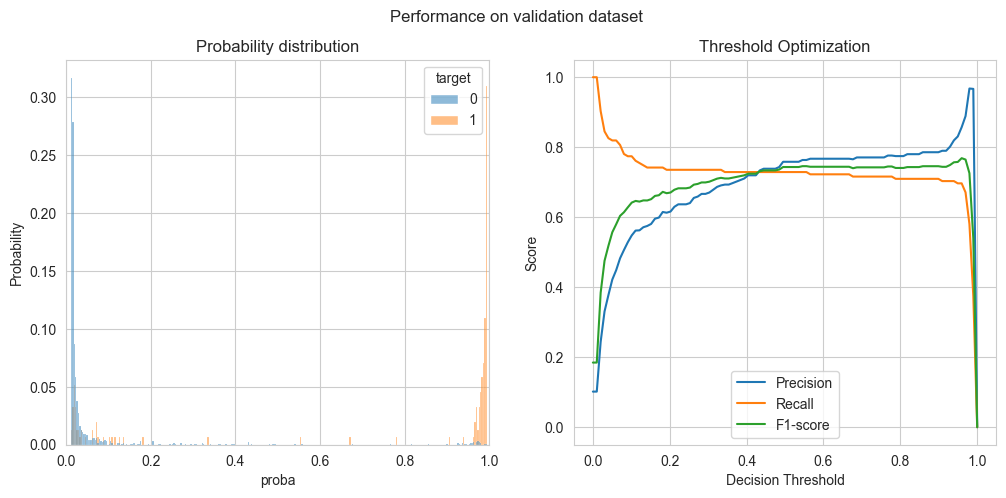

In [38]:
y_pred = trainer.predict(ds_val)
probas = sp.softmax(y_pred.predictions, axis=1)
y_proba = probas[:, 1]

y_true = df_val["target"].to_numpy()
make_plot(y_true, y_proba)

Il y a deux principaux problèmes :
1. **Overfitting** : en regardant les performances au cours de l'entraînement, on voit que la loss pour le train baisse mais pas celle de la validation
2. **Sur-confiance** : les masses sont aux extrêmes des valeurs de probabilités, rendant difficile le choix du seuil

Cela s'explique parce que nous avons ré-entraîné l'ensemble du modèle (les millions de paramètres) avec un learning rate trop aggressif. 

## Amélioration de la procédure

Pour contrer cela, nous allons implémenter plusieurs changement:
* Découper l'entraînement en deux parties :
    1. Entraînement en gelant tous les poids, sauf ceux de la couche de classification sur quelques époques
    2. Entraînement avec l'ensemble des poids sur une à deux époques, avec un learning rate faible
* Ajouter à la fonction de perte du *label smoothing*
* Adapter les scheduler de learning rate, quand c'est nécessaire
* Ajouter du *weight decay*, quand c'est nécessaire

Commençons !



### Intégration du *label smoothing*

Le *label smoothing* est une technique de régularisation introduite dans un [article](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf) améliorant l'architecture Inception. L'idée est d'adresser à la fois le surapprentissage et la sur confiance dans la prédiction.

Concrétement on remplace le vecteur cible $y$ de $K$ classes par :

$$\tilde{y} = (1 - \alpha) y + \frac{\alpha}{K}$$

Avec $\alpha \in [0,1]$ issue de la loi uniforme. De cette manière on évite au logits de devenir trop grand.

**Consigne** : Reprendre la classe `WeightedTrainer` pour ajouter dans la couche de [`CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) le label smoothin valorisé à 0.05

In [44]:
class WeightedTrainer(Trainer):
    """Custom Trainer with weighted loss and label smoothing to handle class imbalance."""

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch=None,
    ):
        """Compute the weighted cross-entropy loss with label smoothing for class imbalance."""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device),
            label_smoothing=0.05,
        )
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


### Premier entraînement

Nous avons besoin de réinitialiser le modèle et geler l'ensemble des couches, sauf celle de classification.

In [45]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

for name, param in model.named_parameters():
    if not name.startswith("classifier"):
        param.requires_grad = False

n_total_parameters = sum(parameters.numel() for parameters in model.parameters())
n_trainable_parameters = sum(
    parameters.numel() for parameters in model.parameters() if parameters.requires_grad
)
rate = n_trainable_parameters / n_total_parameters

print(
    f"{n_trainable_parameters} trainable parameters, {100 * rate:.2f}% of total model parameters",
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


592130 trainable parameters, 0.72% of total model parameters


**Consigne** : Reprendre le paramètrage de `TrainingArguments` et lancer l'entraînement. Stocker les paramétrages, modèles et entraînement dans des variables différentes.

In [47]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_stage_1",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=1e-4,
    weight_decay=0.0,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_strategy="epoch",
    report_to=[],
    save_total_limit=1,
)

trainer_stage_1 = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
)

trainer_stage_1.train()


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=573, training_loss=0.6844227576130972, metrics={'train_runtime': 615.7943, 'train_samples_per_second': 29.679, 'train_steps_per_second': 0.931, 'total_flos': 1210487088918528.0, 'train_loss': 0.6844227576130972, 'epoch': 3.0})

**Consigne** : Observer les performances métriques.

/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


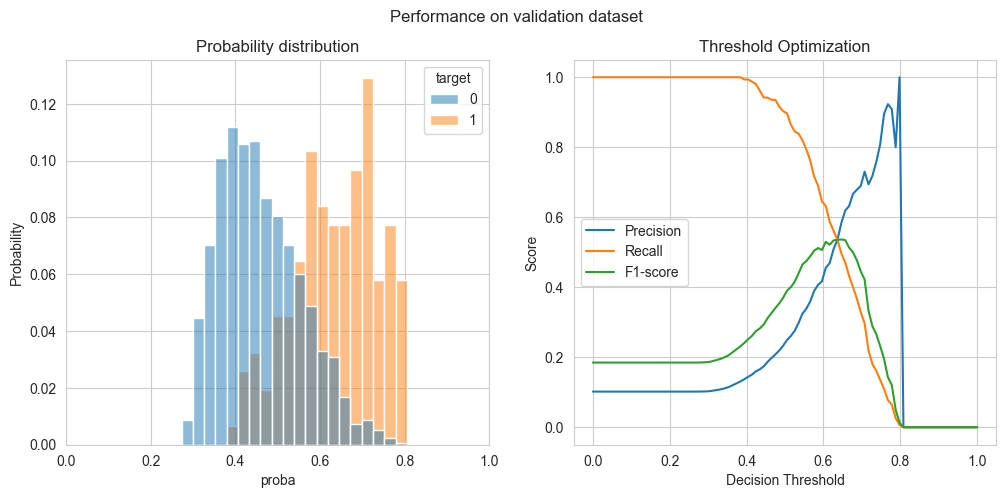

In [48]:
y_pred_1 = trainer_stage_1.predict(ds_val)
probas = sp.softmax(y_pred_1.predictions, axis=1)
y_proba_1 = probas[:, 1]

y_true_1 = df_val["target"].to_numpy()
make_plot(y_true_1, y_proba_1)

### Deuxième entraînement

Cette fois nous allons entraîner l'ensemble des paramètres.

In [49]:
for param in model.parameters():
    param.requires_grad = True

**Consigne** : Reprendre le paramètrage de `TrainingArguments` et le modifier :
* Learning rate beaucoup plus faible
* Nombre d'époque plus réduit
* Ajouter du weight decay
* Modifier le schedule du learning rate pour 'cosine'

Stocker les paramétrages, modèles et entraînement dans des variables différentes. Ne pas réinitialiser en revanche le modèle : nous entraînons des poids déjà modifié.


In [50]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_stage_2",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=1e-4,
    weight_decay=0.0,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_strategy="epoch",
    report_to=[],
    save_total_limit=1,
)

trainer_stage_2 = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
)

trainer_stage_2.train()


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=573, training_loss=0.5150436081811396, metrics={'train_runtime': 1572.2225, 'train_samples_per_second': 11.624, 'train_steps_per_second': 0.364, 'total_flos': 1210487088918528.0, 'train_loss': 0.5150436081811396, 'epoch': 3.0})

On observe une optimisation du même ordre de grandeur que la première itération, mais dans une confiance plus modérée et plus de souplesse dans l'utilisation possible.

/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


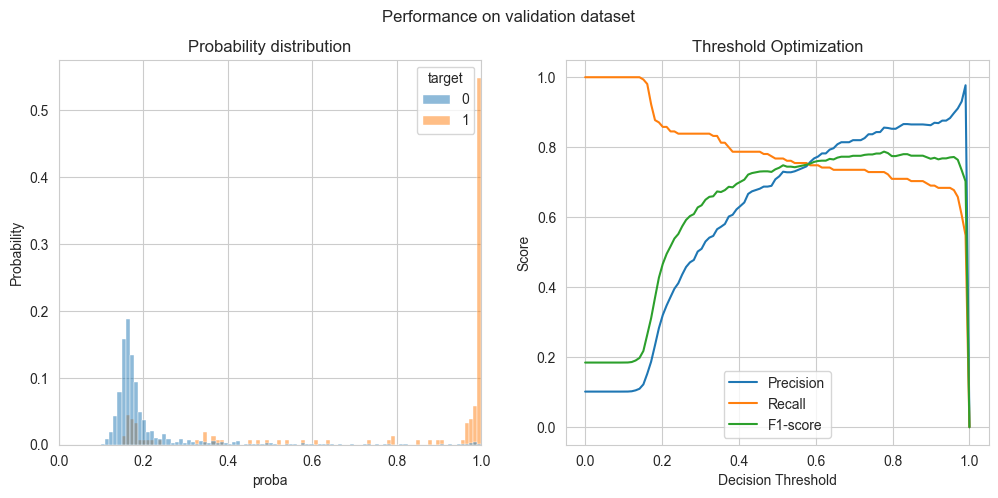

In [51]:
y_pred_2 = trainer_stage_2.predict(ds_val)
probas = sp.softmax(y_pred_2.predictions, axis=1)
y_proba_2 = probas[:, 1]

y_true_2 = df_val["target"].to_numpy()
make_plot(y_true_2, y_proba_2)
